# Setup

Import libraries. For this notebook, I am going to skip all of the data visualization and height only model. Both are in the `PyMC` notebook so there is no real reason to repeat. 

In [16]:
import pandas as pd

from scipy.stats import norm
import numpy as np

import jax.numpy as jnp
from jax import random, vmap
# from jax.scipy.special import 

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
# from numpyro import handlers
from numpyro.infer import MCMC, NUTS


import arviz as az
import xarray as xr 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


mpl.rcParams.update({"font.family":"Arial", 
                     "font.size": 8 ,
                     "axes.labelweight": "bold",
                     "axes.titleweight": "bold",
                     "legend.frameon": False,
                     "text.latex.preamble": r'\boldmath'})

# Define colors
red     = np.divide((232, 24, 40),255)
blue    = np.divide((0, 45, 114),255)
skyblue = np.divide((86, 180, 233),255)
blue_cb = np.divide((0, 114, 178),255)
green   = np.divide((0, 158, 115),255)
pink    = np.divide((204, 121, 167),255)
orange  = np.divide((230, 159, 0),255)
grey    = (.5, .5, .5) 

Load data and standardize

In [12]:
data = pd.read_csv("./data/Howell1.csv",delimiter=';')
adults = data[data.age >= 18]

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()


adults = adults.assign(height_zscore=standardize(adults["height"]),
                       weight_zscore=standardize(adults["weight"]))

adults.head()

,height,weight,age,male,height_zscore,weight_zscore
0,151.765,47.825606,63.0,1,-0.365793,0.439097
1,139.700,36.485807,63.0,0,-1.924109,-1.317185
2,136.525,31.864838,65.0,0,-2.334192,-2.032870
3,156.845,53.041914,41.0,1,0.290340,1.246987
4,145.415,41.276872,51.0,0,-1.185960,-0.575156


# Section 4.4 - Linear prediction

Let's use our linear model for height on weight. 

$$
\begin{align*}
h_i & \sim \text{Normal}(\mu_i, \sigma)\\
\mu_i & = \alpha + \beta(x_i - \bar{x})\\
\alpha & \sim \text{Normal}(178, 20)\\
\beta & \sim \text{Uniform}(0,10) \text{~~or~~} \text{Log-Normal}(0,1) \\
\sigma & \sim \text{Uniform}(0, 50)\\
\end{align*}
$$

In [32]:
# Adapted from here:
# https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html#Model-1:-Predictor---Marriage-Rate

def centered_linear_model(X,y):
    # Prior on weights
    alpha    = numpyro.sample('alpha',dist.Normal(0,10))
    beta     = numpyro.sample('beta' , dist.LogNormal(0,1))

    # Linear model and noise prior
    mu = numpyro.deterministic('mu',alpha + beta*X)
    sigma    = numpyro.sample('sigma',dist.Uniform(0,50))
    
    # Likelihood
    height = numpyro.sample("height",dist.Normal(mu, sigma), obs=y)


# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(centered_linear_model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples,num_chains=4)
mcmc.run(rng_key_, 
         adults["weight_zscore"].to_numpy(),
         adults["height_zscore"].to_numpy())
# mcmc.print_summary()
samples_1 = mcmc.get_samples()
az.summary(mcmc,var_names=["alpha","beta","sigma"])

/var/folders/kx/x_bb9xyn1tg4mnksrmnd_lf00000gn/T/ipykernel_60627/1022469398.py:24: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples,num_chains=4)
sample: 100%|██████████| 3000/3000 [00:00<00:00, 8011.13it/s, 3 steps of size 8.03e-01. acc. prob=0.91]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.000,0.035,-0.064,0.068,0.0,0.0,6669.0,5540.0,1.0
beta,0.754,0.035,0.689,0.820,0.0,0.0,7272.0,5836.0,1.0
sigma,0.659,0.026,0.612,0.708,0.0,0.0,7482.0,5898.0,1.0


This is identical to what we found with `pymc`. It's a simple model, so it is expected, but it is reasurring. 

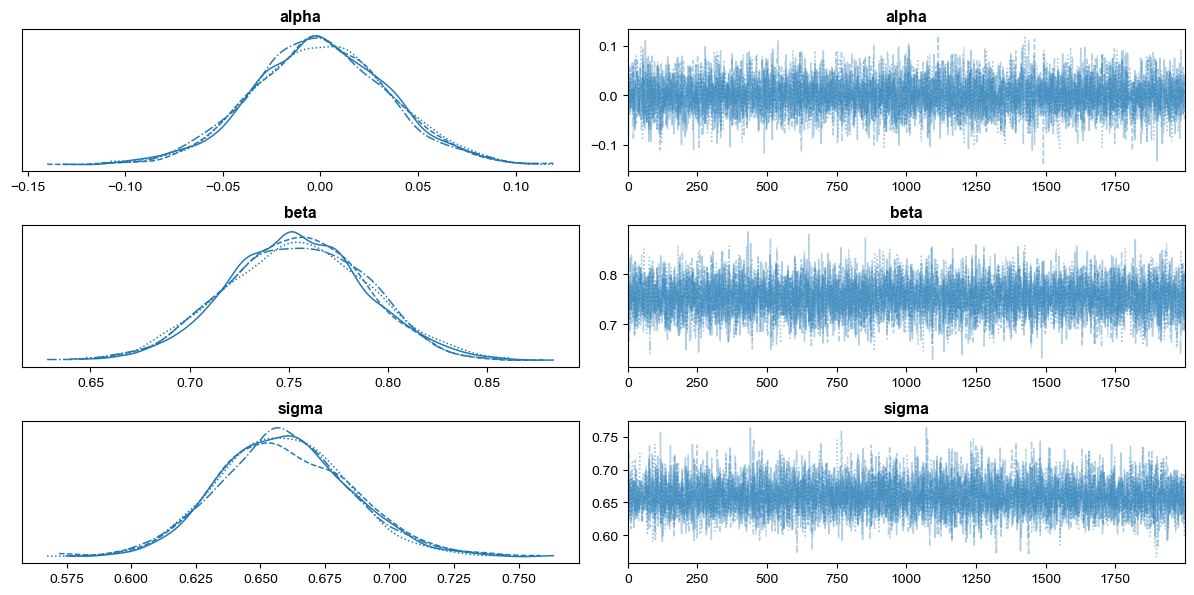

In [33]:
az.plot_trace(mcmc,var_names=["alpha","beta","sigma"])
plt.tight_layout()

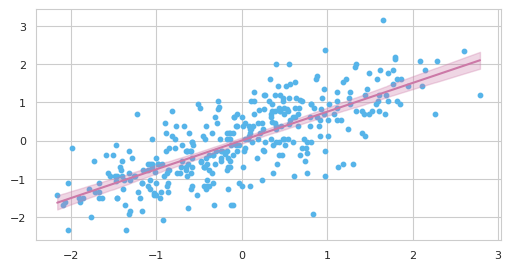

In [53]:
with sns.axes_style("whitegrid"):
    
    # Make figure
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot()

    # Plot observed data
    ax.scatter(data=adults,x="weight_zscore",y="height_zscore",color=skyblue,s=10)

    # Compute empirical posterior distribution over mu
    posterior_mu = (
                    jnp.expand_dims(samples_1["alpha"], -1)
                    + jnp.expand_dims(samples_1["beta"], -1) * adults.weight_zscore.values
                    )   
    mean_mu = jnp.mean(posterior_mu, axis=0)
    hpdi_mu = hpdi(posterior_mu, 0.97)
    
    # Get data and mean line
    weight_data = adults.weight_zscore.to_numpy()
    idx = jnp.argsort(weight_data)
    ax.plot(
            weight_data[idx],
            mean_mu[idx],
            color=pink
            )
    ax.fill_between(weight_data[idx], hpdi_mu[:,idx][0], hpdi_mu[:,idx][1], alpha=0.3, interpolate=True,color=pink)


Great, this looks like expected. The next section in the book (and the `pymc` notebook) is on polynomial models. We are going to skip this since it is almost exactly the same with some additional terms. We are going to move on to the spline regression since it allows us to see what a multiple regression looks like when our multiple regressors (basis functions) are in a matrix, instead of hard coding each vector individually. 

### 4.5.2 Splines!

Since we already did the work of visualizing the basis functions in our `pymc` spline model, we are going to skip all of that and go straight to the model implementation. Let's load the data and build our basis function dataframe. 

In [55]:
data = pd.read_csv('./data/cherry_blossoms.csv',sep=';')

from patsy import dmatrix
num_knots = 15

# This is the key here. Drop the rows where DOY is missing and then compute quantiles on year data
d2 = data.dropna(subset=["doy"]).reset_index(drop=True)
knot_list = np.quantile(d2.year,q=np.linspace(0,1,num_knots))

# Use patsy to compute the basis functions and return dmatrix
basis = dmatrix("bs(x, knots=knots, degree=3,include_intercept=True)-1",
             {"x": d2.year.values, "knots":knot_list[1:-1]})

In [93]:
def spline_model(X,y):
    # Priors on params
    alpha = numpyro.sample("alpha",dist.Normal(100,10))
    betas = numpyro.sample("betas",dist.Normal(0,10).expand([basis.shape[1]]))

    # Likelihood mean and noise
    mu = numpyro.deterministic("mu",alpha + X @ betas)
    sigma = numpyro.sample("sigma",dist.Exponential(1))

    # LIKELIHOOD
    numpyro.sample("y",dist.Normal(mu,sigma),obs=y)


# Run NUTS.
kernel = NUTS(spline_model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples,num_chains=4)
mcmc.run(rng_key_, 
         np.asarray(basis),
         d2.doy.to_numpy())
# mcmc.print_summary()
samples_spline = mcmc.get_samples()
az.summary(mcmc,var_names=["alpha","betas","sigma"])


/var/folders/kx/x_bb9xyn1tg4mnksrmnd_lf00000gn/T/ipykernel_60627/3772064808.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples,num_chains=4)
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2415.69it/s, 63 steps of size 7.55e-02. acc. prob=0.95] 


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,103.428,2.375,99.211,107.964,0.079,0.056,907.0,1777.0,1.0
betas[0],-3.062,3.883,-10.370,4.130,0.087,0.061,2012.0,4560.0,1.0
betas[1],-0.896,3.855,-8.186,6.258,0.087,0.062,1961.0,3726.0,1.0
betas[2],-1.139,3.591,-7.847,5.642,0.087,0.062,1708.0,3652.0,1.0
betas[3],4.766,2.871,-0.396,10.319,0.081,0.057,1265.0,2462.0,1.0
betas[4],-0.930,2.892,-6.194,4.481,0.083,0.059,1224.0,2672.0,1.0
betas[5],4.224,2.908,-1.281,9.493,0.079,0.056,1355.0,2700.0,1.0
betas[6],-5.385,2.822,-10.789,-0.269,0.081,0.057,1209.0,2551.0,1.0
betas[7],7.759,2.821,2.566,13.059,0.082,0.058,1168.0,2313.0,1.0
betas[8],-1.069,2.921,-6.402,4.505,0.080,0.057,1328.0,3178.0,1.0


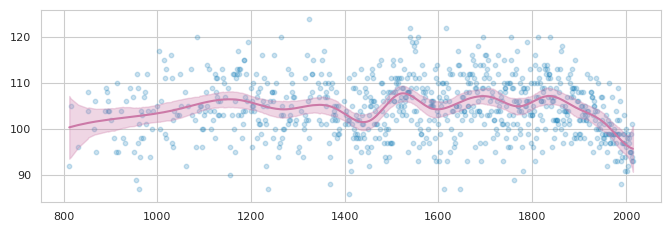

In [94]:

with sns.axes_style("whitegrid"):
    
    # Make figure
    fig = plt.figure(figsize=(8,2.5))
    ax = fig.add_subplot()

    # Plot observed data
    ax.scatter(data=data,x="year",y="doy",color=blue_cb,alpha=0.2,s=10)


    # Compute empirical posterior distribution over mu
    posterior_mu = (
                    jnp.expand_dims(samples_spline["alpha"],-1) +
                    samples_spline["betas"] @ np.asarray(basis).T
                    )
                    
    mean_mu = jnp.mean(posterior_mu, axis=0)
    hpdi_mu = hpdi(posterior_mu, 0.97)
        
    # Get data and mean line
    year_data = d2.year.to_numpy()
    idx = jnp.argsort(year_data)
    ax.plot(
            year_data[idx],
            mean_mu[idx],
            color=pink
            )
    ax.fill_between(year_data[idx], hpdi_mu[:,idx][0], hpdi_mu[:,idx][1], alpha=0.3, interpolate=True,color=pink)
     